In [1]:
import os
import shutil
import random
from PIL import Image, ImageOps
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math

In [2]:
SOURCE_DIR = '/Users/jayvik/Documents/GitHub/AIML/FinalProject/Ghana/Thick/'
SOURCE_IMAGES = os.path.join(SOURCE_DIR, "images")
SOURCE_LABELS = os.path.join(SOURCE_DIR, "labels")

DEST_DIR = '/Users/jayvik/Documents/GitHub/AIML/FinalProject/my_data2/'
DEST_IMAGES = os.path.join(DEST_DIR, "images")
DEST_LABELS = os.path.join(DEST_DIR, "labels")

TRAIN_IMG = os.path.join(DEST_IMAGES, "train")
VAL_IMG   = os.path.join(DEST_IMAGES, "val")
TEST_IMG  = os.path.join(DEST_IMAGES, "test")

TRAIN_LBL = os.path.join(DEST_LABELS, "train")
VAL_LBL   = os.path.join(DEST_LABELS, "val")
TEST_LBL  = os.path.join(DEST_LABELS, "test")

PREP_DIR = '/Users/jayvik/Documents/GitHub/AIML/FinalProject/preprocessed/'

for d in [TRAIN_IMG, VAL_IMG, TEST_IMG, TRAIN_LBL, VAL_LBL, TEST_LBL, PREP_DIR]:
    os.makedirs(d, exist_ok=True)

print("Paths set.")


Paths set.


In [3]:
def analyze_image_dimensions(image_directory_path):
    if not os.path.isdir(image_directory_path):
        print(f"Error: Directory not found at {image_directory_path}")
        return

    dimensions = []
    for img_name in os.listdir(image_directory_path):
        if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            try:
                with Image.open(os.path.join(image_directory_path, img_name)) as img:
                    dimensions.append(img.size)
            except Exception as e:
                print(f"Error reading {img_name}: {e}")

    widths, heights = zip(*dimensions)

    print(f"Image count: {len(dimensions)}")
    print(f"Width  - min: {min(widths)}, max: {max(widths)}, avg: {np.mean(widths):.1f}")
    print(f"Height - min: {min(heights)}, max: {max(heights)}, avg: {np.mean(heights):.1f}")

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    axes[0].hist(widths, bins=30, color='skyblue', edgecolor='black')
    axes[0].set_title("Distribution of Image Widths")
    axes[0].set_xlabel("Width (pixels)")
    axes[0].set_ylabel("Frequency")

    axes[1].hist(heights, bins=30, color='salmon', edgecolor='black')
    axes[1].set_title("Distribution of Image Heights")
    axes[1].set_xlabel("Height (pixels)")
    axes[1].set_ylabel("Frequency")

    plt.tight_layout()
    plt.show()

In [4]:
def crop_contour(image_path, label_path, scale_factor=0.5):

    img = cv2.imread(image_path)
    H, W = img.shape[:2]

    # Resize image and convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    small_gray = cv2.resize(gray, (0,0), fx=scale_factor, fy=scale_factor)
    blur = cv2.GaussianBlur(small_gray, (5,5), 0)

    # Otsu threshold + find contours
    _, th = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        if os.path.exists(label_path) and os.path.getsize(label_path) > 0:
            labels = np.loadtxt(label_path, dtype=np.float32).reshape(-1,5)
        else:
            labels = np.empty((0,5), dtype=np.float32)
        return img, labels.tolist(), 0, 0

    # Take largest contour and fit circle
    cnt = max(contours, key=cv2.contourArea)
    (x_s, y_s), r_s = cv2.minEnclosingCircle(cnt)

    x = int(x_s / scale_factor)
    y = int(y_s / scale_factor)
    r = int(r_s / scale_factor)

    # Load labels
    if os.path.exists(label_path) and os.path.getsize(label_path) > 0:
        labels = np.loadtxt(label_path, dtype=np.float32).reshape(-1,5)
    else:
        labels = np.empty((0,5), dtype=np.float32)

    # Get crop bounds and crop the image
    x0, y0 = max(0, x - r), max(0, y - r)
    x1, y1 = min(W, x + r), min(H, y + r)
    cropped = img[y0:y1, x0:x1]
    cropH, cropW = cropped.shape[:2]

    # Remap labels
    updated_labels = []
    if labels.size > 0:
        abs_coords = labels[:, 1:5] * np.array([W, H, W, H], dtype=np.float32)
        x_center, y_center, w_abs, h_abs = abs_coords.T

        mask = (x_center > x0) & (x_center < x1) & (y_center > y0) & (y_center < y1)

        if mask.any():
            valid_cls = labels[mask, 0:1]

            new_x = (x_center[mask] - x0) / cropW
            new_y = (y_center[mask] - y0) / cropH
            new_w = w_abs[mask] / cropW
            new_h = h_abs[mask] / cropH

            updated_labels = np.hstack([
                valid_cls,
                new_x[:,None],
                new_y[:,None],
                new_w[:,None],
                new_h[:,None]
            ]).tolist()

    return cropped, updated_labels, x0, y0

Image count: 3045
Width  - min: 1162, max: 4096, avg: 3921.0
Height - min: 1200, max: 3215, avg: 3028.9


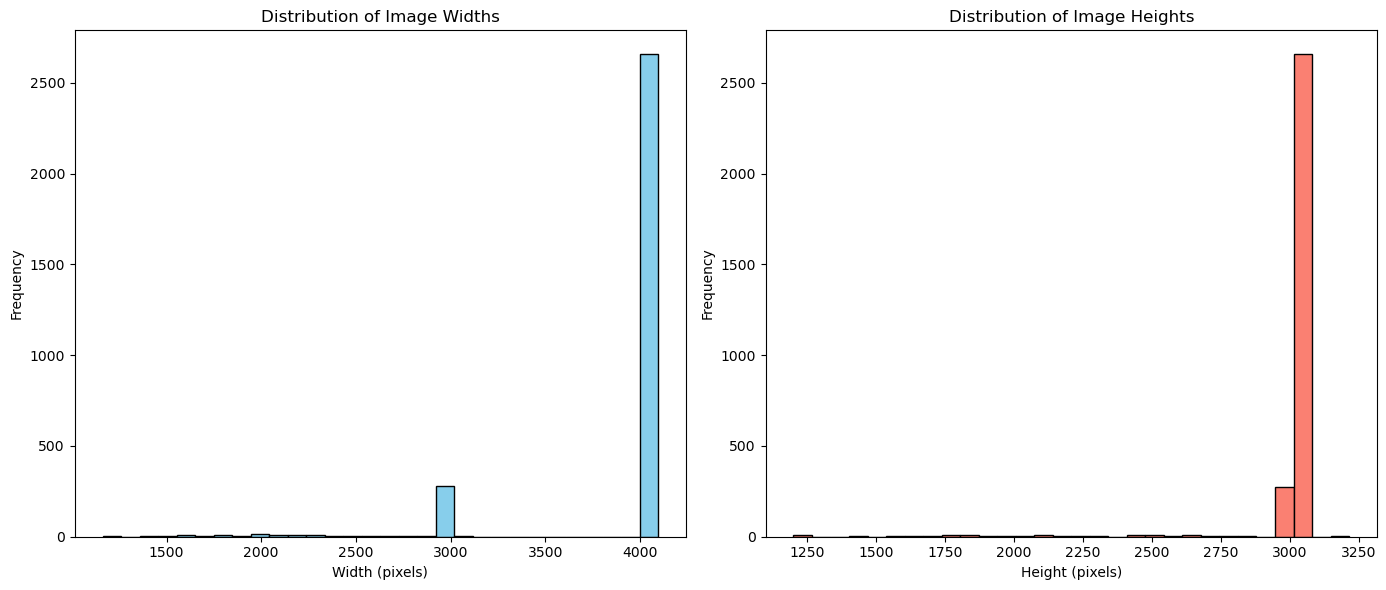

In [5]:
analyze_image_dimensions(SOURCE_IMAGES)

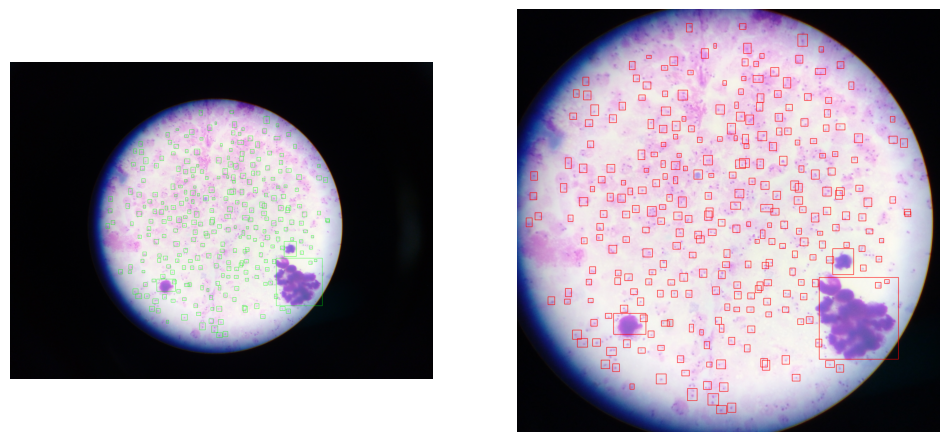

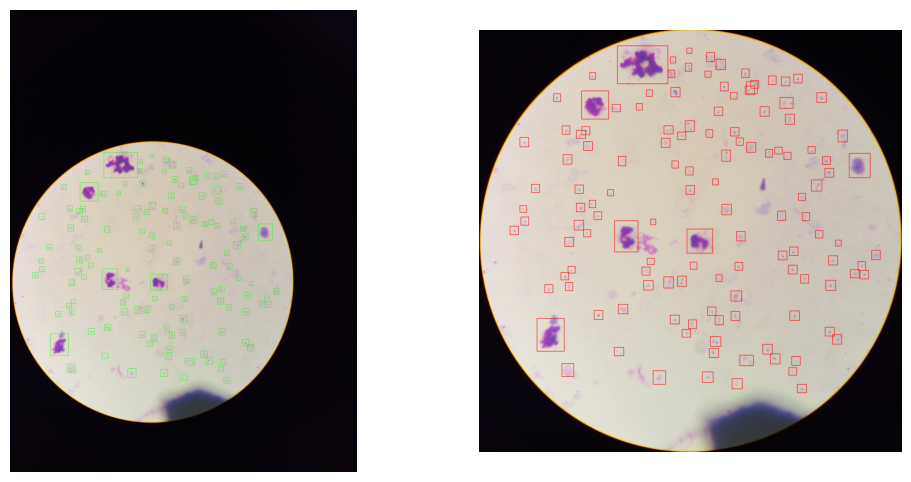

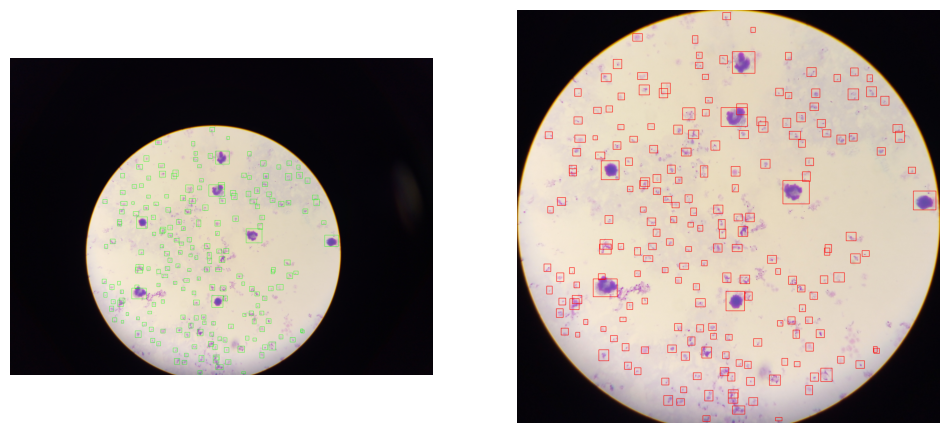

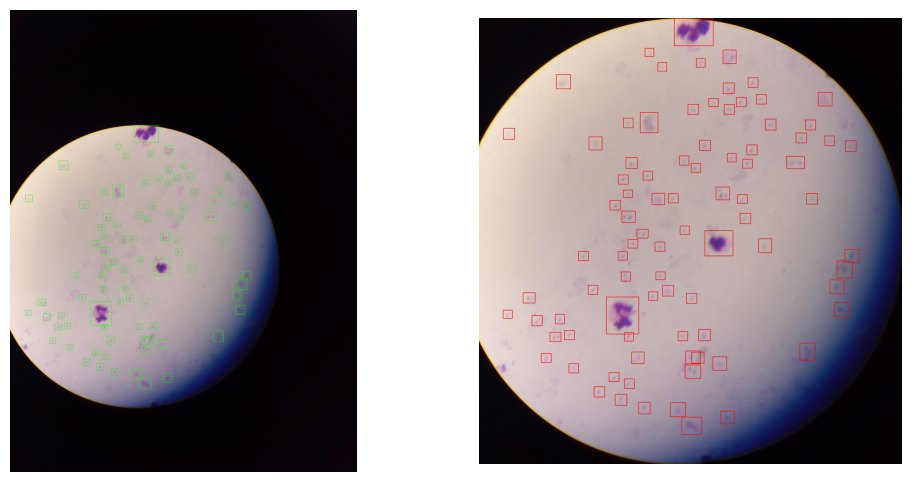

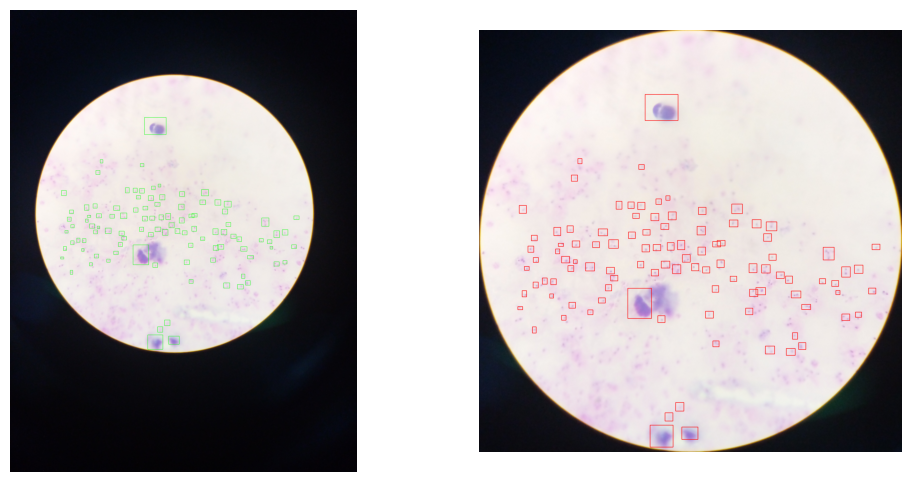

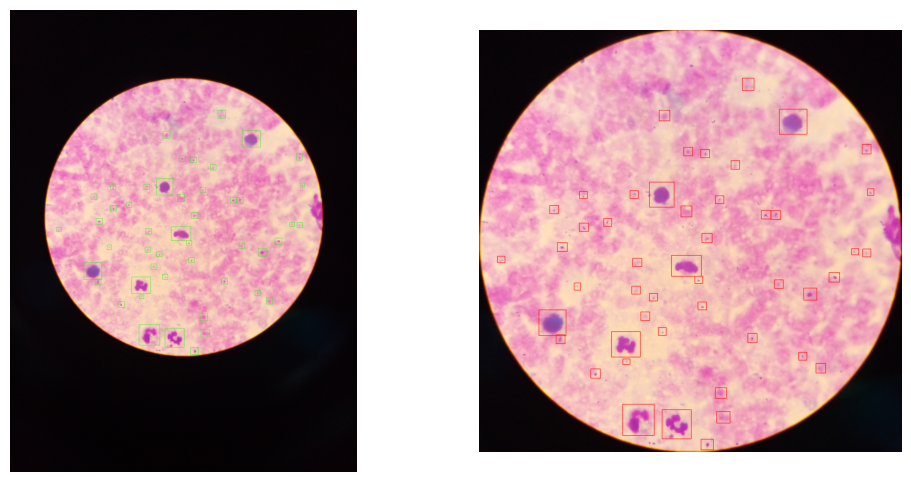

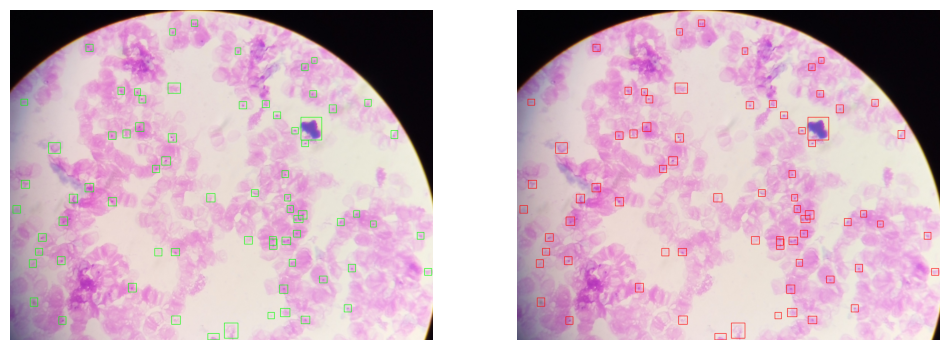

Preprocessing complete. Cropped images and labels saved in: /Users/jayvik/Documents/GitHub/AIML/FinalProject/preprocessed/


In [7]:
image_list = sorted([f for f in os.listdir(SOURCE_IMAGES) if f.lower().endswith(".jpg")])
n = 500 # display every n images

for idx, img_name in enumerate(image_list):
    image_path = os.path.join(SOURCE_IMAGES, img_name)
    label_name = os.path.splitext(img_name)[0] + ".txt"
    label_path = os.path.join(SOURCE_LABELS, label_name)

    # Crop image and update labels
    cropped_img, updated_labels, x0, y0 = crop_contour(image_path, label_path)

    # Load image for visualization
    orig_img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    vis_after = cv2.cvtColor(cropped_img.copy(), cv2.COLOR_BGR2RGB)
    H, W = orig_img.shape[:2]
    cH, cW = cropped_img.shape[:2]
    # Draw labels
    if os.path.exists(label_path):
        for line in open(label_path):
            cls, xc, yc, w, h = map(float, line.split())
            x, y = int(xc*W), int(yc*H)
            w2, h2 = int(w*W)//2, int(h*H)//2
            cv2.rectangle(orig_img, (x-w2, y-h2), (x+w2, y+h2), (0,255,0), 2)
    for cls, xc, yc, w, h in updated_labels:
        x, y = int(xc*cW), int(yc*cH)
        w2, h2 = int(w*cW)//2, int(h*cH)//2
        cv2.rectangle(vis_after, (x-w2, y-h2), (x+w2, y+h2), (255,0,0), 2)
    # Show every n images
    if idx % n == 0:
        plt.figure(figsize=(12,6))
        plt.subplot(1,2,1); plt.imshow(orig_img); plt.axis("off")
        plt.subplot(1,2,2); plt.imshow(vis_after); plt.axis("off")
        plt.show()

    # Save cropped image and updated labels
    save_img_path = os.path.join(PREP_DIR, img_name)
    cv2.imwrite(save_img_path, cropped_img)
    save_label_path = os.path.join(PREP_DIR, label_name)
    with open(save_label_path, "w") as f:
        for cls, xc, yc, w, h in updated_labels:
            f.write(f"{int(cls)} {xc:.6f} {yc:.6f} {w:.6f} {h:.6f}\n")

print("Preprocessing complete. Cropped images and labels saved in:", PREP_DIR)


Image count: 3045
Width  - min: 874, max: 2988, avg: 2520.6
Height - min: 942, max: 3096, avg: 2537.7


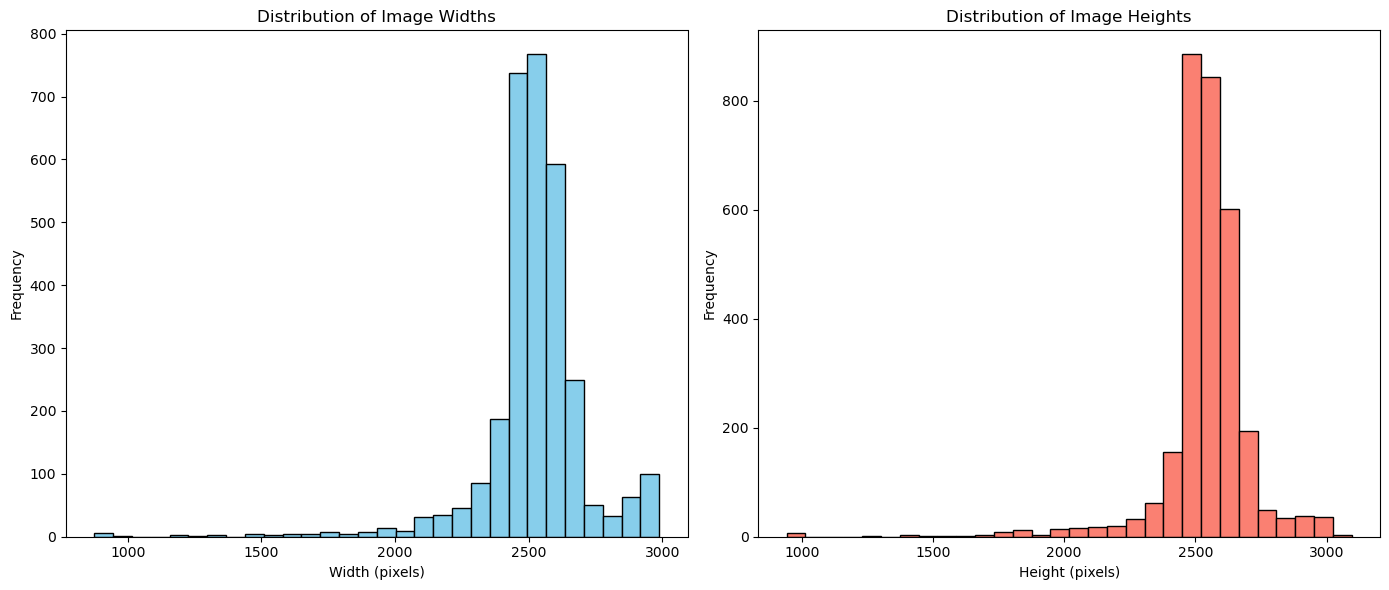

In [8]:
analyze_image_dimensions(PREP_DIR)

In [ ]:
TILE_SIZE = 1280   
OVERLAP = 0  
MIN_BOX_FRAC = 0.005 

train_ratio = 0.7
val_ratio   = 0.2
test_ratio  = 0.1

all_images = images
random.shuffle(all_images)

n = len(all_images)
train_set = set(all_images[:int(n*train_ratio)])
val_set   = set(all_images[int(n*train_ratio):int(n*(train_ratio+val_ratio))])
test_set  = set(all_images[int(n*(train_ratio+val_ratio)):])


def tile_image_and_labels(img_path, lbl_path, base_name):
    TARGET_SIZE = 1280 * 2   # = 2560

    # Read + resize image
    img = cv2.imread(img_path)
    img = cv2.resize(img, (TARGET_SIZE, TARGET_SIZE), interpolation=cv2.INTER_AREA)

    H, W = img.shape[:2]

    # Load labels and convert to absolute coords relative to resized image
    labels = []
    if os.path.exists(lbl_path):
        with open(lbl_path, "r") as f:
            for line in f.readlines():
                cls, xc, yc, w, h = map(float, line.split())

                # Convert normalized → absolute in resized frame
                abs_xc = xc * W
                abs_yc = yc * H
                abs_w  = w  * W
                abs_h  = h  * H
                labels.append((cls, abs_xc, abs_yc, abs_w, abs_h))

    # Compute tile grid
    step = TILE_SIZE - OVERLAP
    nx = math.ceil((W - OVERLAP) / step)
    ny = math.ceil((H - OVERLAP) / step)

    tile_data = []

    for i in range(nx):
        for j in range(ny):
            x0 = i * step
            y0 = j * step
            x1 = x0 + TILE_SIZE
            y1 = y0 + TILE_SIZE

            # Ensure tile stays inside bounds
            if x1 > W:
                x0 = W - TILE_SIZE
                x1 = W
            if y1 > H:
                y0 = H - TILE_SIZE
                y1 = H

            tile_img = img[y0:y1, x0:x1]

            # Process labels inside tile
            tile_labels = []
            for cls, xc, yc, w, h in labels:

                # Convert from center to box coords
                xA = xc - w/2
                yA = yc - h/2
                xB = xc + w/2
                yB = yc + h/2

                # Intersection with tile
                inter_xA = max(xA, x0)
                inter_yA = max(yA, y0)
                inter_xB = min(xB, x1)
                inter_yB = min(yB, y1)

                # If no intersection, skip
                if inter_xA >= inter_xB or inter_yA >= inter_yB:
                    continue

                # Convert intersection back to YOLO normalized coords in tile
                new_w = inter_xB - inter_xA
                new_h = inter_yB - inter_yA
                new_xc = inter_xA + new_w/2 - x0
                new_yc = inter_yA + new_h/2 - y0

                # Tiny box filter
                if (new_w / TILE_SIZE) < MIN_BOX_FRAC or (new_h / TILE_SIZE) < MIN_BOX_FRAC:
                    continue

                # Normalize
                tile_labels.append((
                    cls,
                    new_xc / TILE_SIZE,
                    new_yc / TILE_SIZE,
                    new_w  / TILE_SIZE,
                    new_h  / TILE_SIZE
                ))

            tile_data.append((tile_img, tile_labels, i, j))

    return tile_data

In [ ]:
print("🚀 Starting tiling...")
for img_name in all_images:
    img_path = os.path.join(PREP_DIR, img_name)
    lbl_path = os.path.join(PREP_DIR, img_name.replace(".jpg", ".txt"))

    base = img_name.replace(".jpg", "")

    # Generate tiles
    tiles = tile_image_and_labels(img_path, lbl_path, base)

    # Route to train/val/test
    if img_name in train_set:
        img_out = TRAIN_IMG
        lbl_out = TRAIN_LBL
    elif img_name in val_set:
        img_out = VAL_IMG
        lbl_out = VAL_LBL
    else:
        img_out = TEST_IMG
        lbl_out = TEST_LBL

    # Save tiles
    for tile_img, tile_labels, i, j in tiles:
        tile_name = f"{base}_tile_{i}_{j}.jpg"
        label_name = f"{base}_tile_{i}_{j}.txt"

        cv2.imwrite(os.path.join(img_out, tile_name), tile_img)

        with open(os.path.join(lbl_out, label_name), "w") as f:
            for cls, xc, yc, w, h in tile_labels:
                f.write(f"{int(cls)} {xc:.6f} {yc:.6f} {w:.6f} {h:.6f}\n")

print("Tiling complete!")


🚀 Starting tiling...
✅ Tiling complete!
